# Aula 5 - Sistemas de Recomendação

## Aula 5.1 Distâncias das musicas

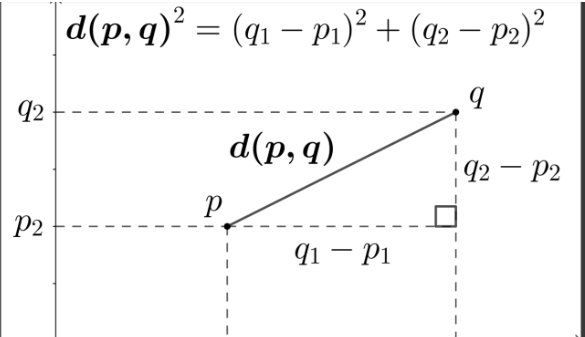

In [ ]:
nome_musica = 'Taylor Swift - Blank Space'

In [ ]:
cluster = projetion_kmeans.filter(projetion_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
cluster

3

In [ ]:
musicas_recomendadas = projetion_kmeans.filter(projetion_kmeans.cluster_pca == cluster)\
                                       .select('artists_song', 'id', 'pca_features')
musicas_recomendadas.show()

+--------------------+--------------------+--------------------+
|        artists_song|                  id|        pca_features|
+--------------------+--------------------+--------------------+
|Usher - Yeah! (fe...|5rb9QrpfcKFHM1EUb...|[-36.050436933493...|
|Kelly Clarkson - ...|3xrn9i8zhNZsTtcoW...|[-35.191226411336...|
| Keyshia Cole - Love|0W4NhJhcqKCqEP2GI...|[-34.751332435196...|
|Mariah Carey - We...|3LmvfNUQtglbTryds...|[-35.144610288312...|
|Korn - Coming Undone|6p2liQLGoDaLXgND6...|[-35.272207170621...|
|Chris Brown - Yo ...|7DFnq8FYhHMCylykf...|[-35.112344117719...|
|  Aventura - Un Beso|1SaEt8dwTuLDzenUu...|[-34.134357732463...|
|Chris Brown - Say...|5F7IJrXD6Fa3EmqoY...|[-34.728839526520...|
|Red Hot Chili Pep...|10Nmj3JCNoMeBQ87u...|[-36.101793760083...|
|Craig Morgan - In...|0Ta3jOf8m9yCSWMVw...|[-35.227552248025...|
|Arctic Monkeys - ...|3geFzA6VBSNZUTmV3...|[-34.696049351615...|
|Arctic Monkeys - 505|58ge6dfP91o9oXMzq...|[-35.057671072817...|
|T-Pain - Buy U a ...|2aI

In [ ]:
componenetes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
                                          .select('pca_features').collect()[0][0]
componenetes_musica                             

DenseVector([-35.461, -166.9658, -12.7925, -137.9457, -13.1234, 4.1374])

## Aula 5.2 Recomendação da música

In [ ]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType

In [ ]:
def calcula_distance(value):
  return euclidean(componenetes_musica, value)

udf_calcula_distance = f.udf(calcula_distance, FloatType())

musicas_recomendadas_dist = musicas_recomendadas.withColumn('Dist', udf_calcula_distance('pca_features'))

recomendadas = sessao_spark.createDataFrame(musicas_recomendadas_dist.sort('Dist').take(10)).select(['artists_song', 'id', 'Dist'])

recomendadas.show()

+--------------------+--------------------+-------------------+
|        artists_song|                  id|               Dist|
+--------------------+--------------------+-------------------+
|Taylor Swift - Bl...|1p80LdxRV74UKvL8g...|                0.0|
|Imagine Dragons -...|4uGY9CqDtGtaTTLg1...|0.37921473383903503|
|The All-American ...|6ihL9TjfRjadfEePz...| 0.6039153933525085|
|Darius Rucker - B...|36ISlLb12gKuCCVTY...| 0.6824935674667358|
|Old Dominion - Sn...|7I5fYc4qKJddht8Oz...| 0.7364036440849304|
|Dan + Shay - Noth...|4W38RXuQNuoTSwVsQ...| 0.7841535210609436|
|Twenty One Pilots...|7qxjGHW485TL8ciwk...| 0.8002141118049622|
|Jon Bellion - Mor...|2JXNOtb0ANe6MzgRY...| 0.8098159432411194|
|Kip Moore - More ...|73WWkaWkIRSP3MYGZ...| 0.8557121753692627|
|Calibre 50 - Corr...|0ehx1p1HMn7NMKisZ...| 0.8788507580757141|
+--------------------+--------------------+-------------------+



In [ ]:
def recomendador(nome_musica):
  cluster = projetion_kmeans.filter(projetion_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
  musicas_recomendadas = projetion_kmeans.filter(projetion_kmeans.cluster_pca == cluster)\
                                       .select('artists_song', 'id', 'pca_features')
  componenetes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
                                          .select('pca_features').collect()[0][0]

  def calcula_distance(value):
    return euclidean(componenetes_musica, value)

  udf_calcula_distance = f.udf(calcula_distance, FloatType())

  musicas_recomendadas_dist = musicas_recomendadas.withColumn('Dist', udf_calcula_distance('pca_features'))

  recomendadas = sessao_spark.createDataFrame(musicas_recomendadas_dist.sort('Dist').take(10)).select(['artists_song', 'id', 'Dist'])

  recomendadas.select('artists_song').show(truncate=False)


In [ ]:
recomendador('Taylor Swift - Blank Space')

+-----------------------------------------+
|artists_song                             |
+-----------------------------------------+
|Taylor Swift - Blank Space               |
|Imagine Dragons - Machine                |
|The All-American Rejects - Gives You Hell|
|Darius Rucker - Beers And Sunshine       |
|Old Dominion - Snapback                  |
|Dan + Shay - Nothin' Like You            |
|Twenty One Pilots - Not Today            |
|Jon Bellion - Morning In America         |
|Kip Moore - More Girls Like You          |
|Calibre 50 - Corrido De Juanito          |
+-----------------------------------------+



## Aula 5.3 Biblioteca Spotipy

In [ ]:
!pip install spotipy

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials

**ATENÇÃO!**

Antes de rodar essa parte do código, você precisa fazer uma conta na API do Spotify e gerar suas próprias **client_id** e **client_secret**

In [ ]:
scope = "user-library-read playlist-modify-private"

OAuth = SpotifyOAuth(
        scope=scope,         
        redirect_uri='http://localhost:5000/callback',
        client_id = '566b010ba65541ebb537ea12f225fee3',
        client_secret = '0d71d1191ca7418d9af15433c6acfd62')

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id = '566b010ba65541ebb537ea12f225fee3',
                                                      client_secret = '0d71d1191ca7418d9af15433c6acfd62')

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
id = projetion_kmeans.filter(projetion_kmeans.artists_song == nome_musica).select('id').collect()[0][0]
id

'1p80LdxRV74UKvL8gnD7ky'

In [ ]:
sp.track(id)

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/06HL4z0CvFAxyc27GXpf02'},
    'href': 'https://api.spotify.com/v1/artists/06HL4z0CvFAxyc27GXpf02',
    'id': '06HL4z0CvFAxyc27GXpf02',
    'name': 'Taylor Swift',
    'type': 'artist',
    'uri': 'spotify:artist:06HL4z0CvFAxyc27GXpf02'}],
  'available_markets': ['CA', 'US'],
  'external_urls': {'spotify': 'https://open.spotify.com/album/2QJmrSgbdM35R67eoGQo4j'},
  'href': 'https://api.spotify.com/v1/albums/2QJmrSgbdM35R67eoGQo4j',
  'id': '2QJmrSgbdM35R67eoGQo4j',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/ab67616d0000b2739abdf14e6058bd3903686148',
    'width': 640},
   {'height': 300,
    'url': 'https://i.scdn.co/image/ab67616d00001e029abdf14e6058bd3903686148',
    'width': 300},
   {'height': 64,
    'url': 'https://i.scdn.co/image/ab67616d000048519abdf14e6058bd3903686148',
    'width': 64}],
  'name': '1989',
  'release_date': '2014-10-27',
  'release

In [ ]:
def recomendador(nome_musica):
  # Calcula musicas recomendadas
  cluster = projetion_kmeans.filter(projetion_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
  musicas_recomendadas = projetion_kmeans.filter(projetion_kmeans.cluster_pca == cluster)\
                                       .select('artists_song', 'id', 'pca_features')
  componenetes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
                                          .select('pca_features').collect()[0][0]

  def calcula_distance(value):
    return euclidean(componenetes_musica, value)

  udf_calcula_distance = f.udf(calcula_distance, FloatType())

  musicas_recomendadas_dist = musicas_recomendadas.withColumn('Dist', udf_calcula_distance('pca_features'))

  recomendadas = sessao_spark.createDataFrame(musicas_recomendadas_dist.sort('Dist').take(10)).select(['artists_song', 'id', 'Dist'])

  recomendadas.select('artists_song').show(truncate=False)

  #Pegar informações da API

  playlist_id = recomendadas.select('id').collect()

  playlist_track = []

  for id in playlist_id:
    playlist_track.append(sp.track(id[0]))

  return len(playlist_track)

In [ ]:
recomendador('Taylor Swift - Blank Space')

+-----------------------------------------+
|artists_song                             |
+-----------------------------------------+
|Taylor Swift - Blank Space               |
|Imagine Dragons - Machine                |
|The All-American Rejects - Gives You Hell|
|Darius Rucker - Beers And Sunshine       |
|Old Dominion - Snapback                  |
|Dan + Shay - Nothin' Like You            |
|Twenty One Pilots - Not Today            |
|Jon Bellion - Morning In America         |
|Kip Moore - More Girls Like You          |
|Calibre 50 - Corrido De Juanito          |
+-----------------------------------------+



10

https://developer.spotify.com/documentation/web-api/reference/#/operations/get-track

## Aula 5.3 Imagem do álbum

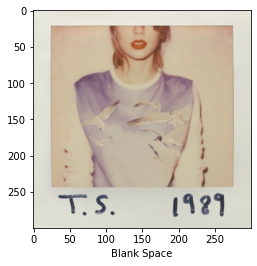

In [ ]:
import matplotlib.pyplot as plt
from skimage import io

nome_musica = 'Taylor Swift - Blank Space'

id = projetion_kmeans\
          .filter(projetion_kmeans.artists_song == nome_musica)\
          .select('id').collect()[0][0]

track = sp.track(id)

url = track["album"]["images"][1]["url"]
name = track["name"]

image = io.imread(url)
plt.imshow(image)
plt.xlabel(name, fontsize = 10)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from skimage import io

def visualize_songs(name,url):

    plt.figure(figsize=(15,10))
    columns = 5
    for i, u in enumerate(url):
        ax = plt.subplot(len(url) // columns + 1, columns, i + 1)
        image = io.imread(u)
        plt.imshow(image)
        ax.get_yaxis().set_visible(False)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(name[i], fontsize = 10)
        plt.tight_layout(h_pad=0.7, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.grid(visible=None)
        #plt.axis('off')
    plt.show()

In [ ]:
playlist_id = recomendada.select('id').collect()

name = []
url = []
for i in playlist_id:
    track = sp.track(i[0])
    url.append(track["album"]["images"][1]["url"])
    name.append(track["name"])

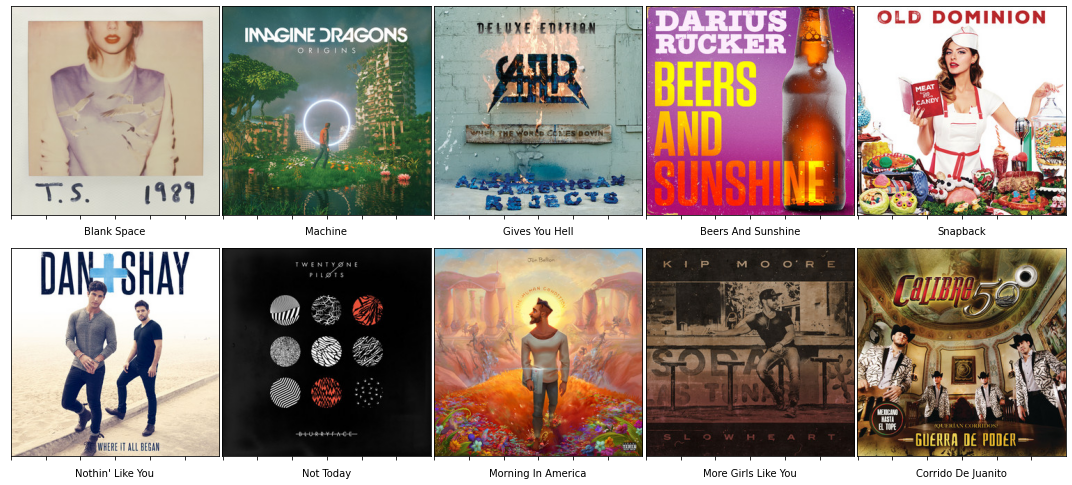

In [ ]:
visualize_songs(name,url)

In [ ]:
def recomendador(nome_musica):
  # Calcula musicas recomendadas
  cluster = projetion_kmeans.filter(projetion_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
  musicas_recomendadas = projetion_kmeans.filter(projetion_kmeans.cluster_pca == cluster)\
                                       .select('artists_song', 'id', 'pca_features')
  componenetes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
                                          .select('pca_features').collect()[0][0]

  def calcula_distance(value):
    return euclidean(componenetes_musica, value)

  udf_calcula_distance = f.udf(calcula_distance, FloatType())

  musicas_recomendadas_dist = musicas_recomendadas.withColumn('Dist', udf_calcula_distance('pca_features'))

  recomendadas = sessao_spark.createDataFrame(musicas_recomendadas_dist.sort('Dist').take(10)).select(['artists_song', 'id', 'Dist'])

  #Pegar informações da API

  playlist_id = recomendadas.select('id').collect()

  name = []
  url = []
  for i in playlist_id:
      track = sp.track(i[0])
      url.append(track["album"]["images"][1]["url"])
      name.append(track["name"])

  #Plotando capas 

  plt.figure(figsize=(15,10))
  columns = 5
  for i, u in enumerate(url):
      ax = plt.subplot(len(url) // columns + 1, columns, i + 1)
      image = io.imread(u)
      plt.imshow(image)
      ax.get_yaxis().set_visible(False)
      plt.xticks(color = 'w', fontsize = 0.1)
      plt.yticks(color = 'w', fontsize = 0.1)
      plt.xlabel(name[i], fontsize = 10)
      plt.tight_layout(h_pad=0.7, w_pad=0)
      plt.subplots_adjust(wspace=None, hspace=None)
      plt.grid(visible=None)
      #plt.axis('off')
  plt.show()

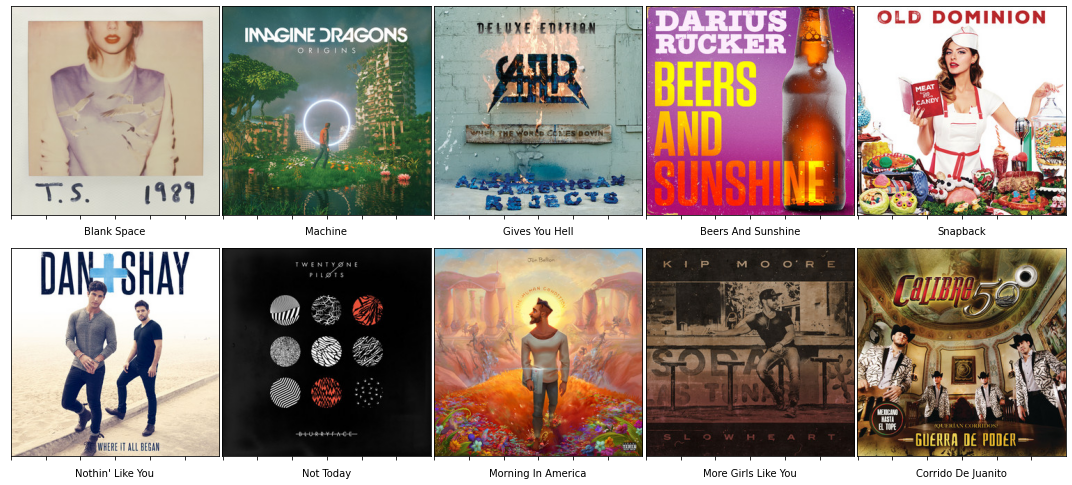

In [ ]:
recomendador('Taylor Swift - Blank Space')

## Aula 5.4 Conclusão